In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#print options to data exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Our goal is to form two linear regression models, one which predicts the number of new cases per million and another which predicts the number of new deaths per million in a given country. We are particularly interested in understanding the influence which the prevalence of specific variants has on our response variables. Thus, we limit our analysis to only those rows containing variant level data which is published on a roughly biweekly basis. We load in this data set in the cell below, removing columns that are redunadant and not scaled by the country's population size.

In [165]:
personal_path = '/content/drive/My Drive/ML Final Project/'
path_full = os.path.join(personal_path, "Data/logan_biweekly_new.csv")
df = pd.read_csv(path_full)
df = df.iloc[:, 1:]
df.head()
df.drop(['continent','location','total_cases','new_cases','new_cases_smoothed','total_deaths','new_deaths',
         'new_deaths_smoothed','new_cases_per_million','new_deaths_per_million',
         'icu_patients','hosp_patients','weekly_icu_admissions','total_tests','new_tests',
         'new_tests_per_thousand','new_tests_smoothed','total_vaccinations','weekly_hosp_admissions',
         'people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations',
         'new_vaccinations_smoothed','new_people_vaccinated_smoothed','excess_mortality_cumulative',
         'excess_mortality_cumulative_absolute','daily_people_vaccinated','daily_vaccinations',
         'daily_vaccinations_raw','tests_units'], axis=1, inplace=True)

Prior to model creation we must first examine the role which missing data plays in our data set. We begin this analysis by first examining the proportion of rows which contain missing data for each feature. 

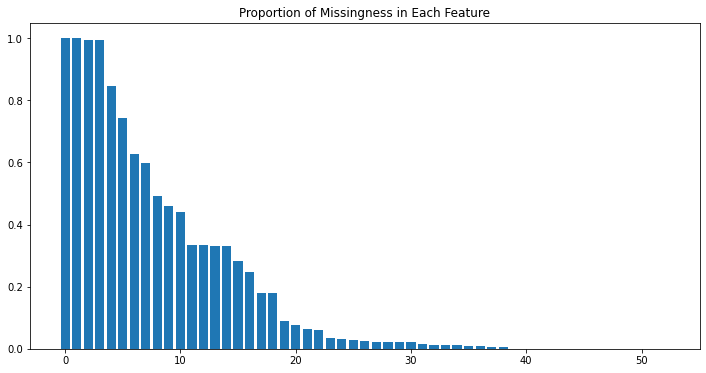

In [166]:
plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(0, len(df.columns)), height = np.sort(df.isna().sum() / len(df))[::-1])
plt.title('Proportion of Missingness in Each Feature')
plt.show()

We see that a number of features are almost entirely missing. These features should be removed from consideration as dropping all rows in which the feature is missing will result in a substantial reduction in our data set's size and imputation methods will likely be wildly inaccurate. Observing the bar chart we see a substantial drop off in the proportion of missingness between the sixth and seventh most missing features. To drop the 6 most missing features we use a threshold of 65%.

In [167]:
df = df.loc[:, df.isna().sum() / len(df) < 0.65]

Now we must determine if the data is Missing Completly at Random (MCAR). If it is we can safetly drop the rows containing missing data and conduct our analysis on the rows which remain. To make this detirmination we first a create a binary column for each feature which denotes missingness. Using our notation from lecture these columns encode the $R_i$.

In [168]:
df_missing = df.copy()

#create the R_i columns
Ri = []
for column in df_missing.columns:
  df_missing[str(column) + '_na'] = pd.isna(df[column]).astype(int)

#remove Ri columns corresponding to non-missing/fully observed features
df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
Ri = df_missing.columns[48:]
print(Ri)

Index(['new_cases_smoothed_per_million_na', 'total_deaths_per_million_na',
       'new_deaths_smoothed_per_million_na', 'reproduction_rate_na',
       'icu_patients_per_million_na', 'hosp_patients_per_million_na',
       'total_tests_per_thousand_na', 'new_tests_smoothed_per_thousand_na',
       'positive_rate_na', 'tests_per_case_na',
       'total_vaccinations_per_hundred_na', 'people_vaccinated_per_hundred_na',
       'people_fully_vaccinated_per_hundred_na',
       'new_vaccinations_smoothed_per_million_na',
       'new_people_vaccinated_smoothed_per_hundred_na', 'stringency_index_na',
       'population_na', 'population_density_na', 'median_age_na',
       'aged_65_older_na', 'aged_70_older_na', 'gdp_per_capita_na',
       'extreme_poverty_na', 'cardiovasc_death_rate_na',
       'diabetes_prevalence_na', 'female_smokers_na', 'male_smokers_na',
       'hospital_beds_per_thousand_na', 'life_expectancy_na',
       'human_development_index_na', 'daily_people_vaccinated_per_hundred_na'

Next we look to see if there is a correlation between the country and what data is missing. Since both the country and the $R_i$ are categorical variables this can be done with a hypothesis test known as a $\chi^2$-contigency test. The null hypothesis of this test is $H_0$: the variables are independent. In the below cell we perform 32 such tests, one for every (iso_code, $R_i$) pair.

In [169]:
import scipy.stats as ss

p_vals = []
for col in Ri:
  M = pd.crosstab(df_missing['iso_code'], df_missing[col])
  p_vals.append(ss.chi2_contingency(M)[1])
print(len(p_vals))

32


All of the p-values are extraordinarily small, practically zero. This means that every feature's missingness is correlated with the country. To be more formal we should utilize a Bonferroni Correction for simulatenous inference. Thus, instead of conducting the test at a 95% confidence level which corresponds to $\alpha = 0.05$ we instead use $\alpha = \frac{0.05}{34} = 0.0015.$ However, even with this correction every p-value falls below the 0.0015 threshold.

We are also interested in detirmining if any of the continuous features are correlated with missingness. To make this detirmination we employ a Kruskal-Wallace test which takes in a quantitative and categorigal variable, splits the quantitative variable into groups based on the categorical variable's value and attempts to determine if the medians of the quantitative variables in each group differ significantly from each other. The null hypohtesis is $H_0$: medians of the groups are the same.

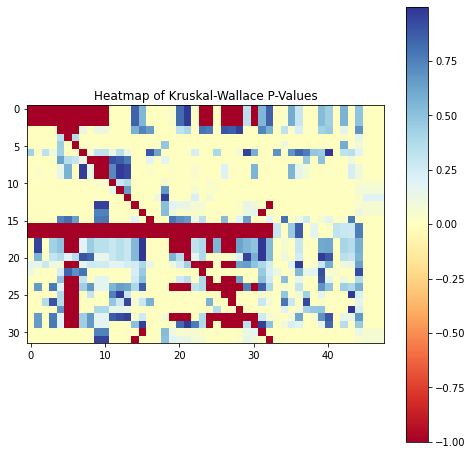

In [170]:
#drop categorical features
df_missing.drop(['iso_code','date'], axis=1, inplace = True)
#columns of quantitative features
quant_cols = df_missing.columns[:48]


#initialize data structure to hold p-values
arr = np.zeros((len(Ri), len(quant_cols)))
for i, missing_col in enumerate(Ri):
  for j, old_col in enumerate(quant_cols):
    #remove rows in which the quantitative predictor is missing
    df_sub = df_missing[df_missing[old_col].notna()]
    #group by the R_i into those rows with 0 and those with 1
    g = df_sub.groupby(missing_col)
    val_list = []
    for val in df_sub[missing_col].unique():
      #get the quantitative column of interest for each group
      val_list.append(g.get_group(val)[old_col])
    #if neither group is empty
    if len(val_list) > 1: arr[i,j] = ss.kruskal(*val_list).pvalue
    else: arr[i,j] = -1

missingness_corr = pd.DataFrame(arr)

plt.figure(figsize=(8, 8))
plt.imshow(missingness_corr, cmap ="RdYlBu")
plt.colorbar()
plt.title('Heatmap of Kruskal-Wallace P-Values')
plt.show()

In the above heat map each cell corresponds to the p-value of a single Kruskal-Wallace test between a quantitative feature and an $R_i$. The dark red cells correspond to p-values of -1 which denote instances where the Kruskal-Wallace test could not be completed because the $R_i$ was always 0 or always 1 when the quantitative feature was present. The pale yellow cells denote near zero p-values of which there are many. These cells denote combinations of quantititave features and $R_i$ which are unlikely to be independent. Thus, through quick visual inspection we can detirmine that there is a lot of dependence between the $R_i$ and observed data in the data set.

Through the above analysis we can firmly conclude that we are not the our data is not MCAR and so we cannot drop rows which contain missing data Instead we will assume for the purposes of our further analysis that our data is MAR and leverage imputation techniques to make educated guesses about the values of the underlying $X_i^{(1)}$

Simple imputation techniques such as filling in missing values with the feature's mean, median, or mode are unlikely to sufficient given the complexity and amount of missingness present in the data set. Feed-forward imputation in which missing data is imputed with the feature's value in the last row it was present could potentially yeild usable results since our data has a time series component. However, such a technique fails to leverage information about the observed data in the row which could have strong predictive power. K-Nearest Neighbors imputation, in which missing data is filled with the data of similar/nearby points was also considered. However, while such a technique does indeed leverage observed data KNN is not ideal in high dimensional situations such as ours since "all points in high dimensions are lonely," the curse of dimensionality strikes again! Finally, we considered a iterative linear regression imputation approach in which each feature with missing data is fitted with a linear regression model which uses the other features as predicted. This is done iteratively, over any rounds until convergence. This approach allows us to leverage our observed data while not succumbing to the curse of dimensionality.

The iterative linear regression approach is implmented in the cell below. Note that dummy variables are created for country and month/year to give the imputation model more predictive ability.

In [175]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

imp = IterativeImputer(estimator = BayesianRidge(), max_iter = 100, random_state=42)
df_temp = df.drop(['iso_code','date'], axis=1)
df_imputed = pd.DataFrame(imp.fit_transform(df_temp))
df_imputed.columns = df_temp.columns
df_imputed['iso_code'] = df['iso_code']
df_imputed['date'] = df['date']